In [7]:
import numpy as np
from scipy.stats import norm
from scipy.special import logsumexp
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
import torch
from matplotlib import interactive
import math
interactive(True)
%matplotlib notebook

## Depth as a probabilistic representation
We wish to estimate the depth map $\mathbf{D} = \{d_{u, v}\}$ of the scene, which specifies the depth value $d_{u, v}$ for every camera pixel $(u, v)$ at spatial resolution [H,W]. Since there is inherent uncertainty in the depth value at every pixel, we represent a \textit{probability distribution} over depths for every pixel. Let us define $\mathbf{d}_{u,v}$ to be a random variable for depth predictions at the pixel $(u, v)$. We quantize depth values into a set $D = \{d_0, \dots, d_{N-1}\}$ of $N$ discrete, uniformly spaced depth values lying in $(d_\text{min}, d_\text{max})$. All the predictions $\mathbf{d}_{u, v} \in D$ belong to this set. The output of our depth estimation method for each pixel is a probability distribution $P(\mathbf{d}_{u, v})$, modeled as a categorical distribution over $D$. In this work, we use $N=128$, resulting in a Depth Probability Volume (DPV) tensor of size [128, W, H]:

   $D=\{d_0, \dots, d_{N-1}\}; d_{q}=d_\text{min}+(d_\text{max}-d_\text{min}) \cdot q$
   
   $\sum_{q=0}^{N-1} P(\mathbf{d}_{u,v} = d_q) =1 \ \text{(q is the quantization index)}$
   

   $\text{Depth estimate } = \mathbb{E} [ \mathbf{d}_{u,v}] = \sum_{q=0}^{N-1} P(\mathbf{d}_{u,v}=d_q)\cdot d_q$


In [8]:
N = 128
D = np.linspace(start=20.0/N, stop=20.0, num=N)  # 20 meters, 64 subdivisions
t = D

## Observation Model

![Sweep](https://github.com/soulslicer/adap-fusion/blob/master/pics/sweep.png?raw=true)

A curtain placement corresponds to specifying the depth for each camera ray indexed by $u$ from the top-down view. After placing the light curtain, intensities $i_{u,v}$ are imaged by the light curtain's camera at every pixel $(u, v)$. The measured intensity at each pixel is a function of the curtain placement depth $d^c_{u, v}$ on that camera ray, the unknown ground truth depth $\mathbf{d}_{u, v}$ of that pixel, the thickness of the light curtain $\sigma(u, v, d^c_{u, v})$ for a particular pixel and curtain placement, and the maximum intensity possible if a curtain is placed perfectly on the surface $p_{u,v}$ (varies from 0 to 1). We find  the intensity decays exponentially as the distance between the curtain placement $d^c_{u.v}$ and ground truth depth $\mathbf{d}_{u, v}$ increases, with the scaling factor $p_{u,v}$ parameterizing the surface properties. We also simulate sensor noise as a Gaussian distribution with standard deviation $\sigma_\text{nse}$. The overall sensor model $P(i_{u, v}\ |\ \mathbf{d}_{u, v}, d^c_{u, v})$ can be described as:

$P(i_{u, v}\ |\ \mathbf{d}_{u, v}, d^c_{u, v}) \equiv
\mathcal{N}\Big(i_{u,v}\ |\ \exp\Big(-\Bigg(\frac{d_{u,v}^{c}-d_{u,v}}{\sigma(u,v,d_{u,v}^{c})}\Bigg)^{2}\Big).p_{u,v},\sigma_{\text{nse}}^{2}\Big)$

In [9]:
# Observation Model
def observation_model(placement, intensity, inten_sigma, noise_sigma, peak):
    mean_intensities = []
    for d in D:
        error = np.abs(d - placement)
        mean_intensity = np.exp(- (error / inten_sigma) ** 2)  # intensity exponential falloff
        mean_intensities.append(mean_intensity*peak)

    return mean_intensities

How do we incorporate the newly acquired information about the scene from the light curtain to update our current beliefs of object depths? Since we have a probabilistic sensor model, we use the Bayes' rule to infer the posterior distribution of the ground truth depths given the observations. Let $P_\text{prev}(u, v, q)$ denote the probability of the depth at pixel $(u, v)$ being equal to $d_q$ before sensing, and $P_\text{next}(u, v, q)$ the updated probability after sensing. Then by Bayes' rule:

$P_\text{next}(u, v, q) = P(\mathbf{d}_{u, v} = d_q\ |\ i_{u, v}, d^{c_k}_{u, v}) $

$\hspace{3pt}= \frac{P(\mathbf{d}_{u,v}=d_{q})\cdot P(i_{u,v}\ |\ \mathbf{d}_{u,v}=d_{q},d_{u,v}^{c_{k}})}{P(i_{u,v}\ |\ d_{u,v}^{c_{k}})}$

$\hspace{3pt}= \frac{P(\mathbf{d}_{u,v}=d_{q})\cdot P(i_{u,v}\ |\ \mathbf{d}_{u,v}=d_{q},d_{u,v}^{c_{k}})}{P(i_{u,v}\ |\ d_{u,v}^{c_{k}})}$

$\hspace{3pt}= \frac{P(\mathbf{d}_{u,v}=d_{q})\cdot P(i_{u,v}\ |\ \mathbf{d}_{u,v}=d_{q},d_{u,v}^{c_{k}})}{\sum_{q'=0}^{N-1}P(\mathbf{d}_{u,v}=d_{q'})\cdot P(i_{u,v}\ |\ \mathbf{d}_{u,v}=d_{q'},d_{u,v}^{c_{k}})}$

$\frac{P_\text{prev}(u, v, q)\cdot P(i_{u,v}\ |\ \mathbf{d}_{u,v}=d_{q},d_{u,v}^{c_{k}})}{\sum_{q'=0}^{N-1}P_\text{prev}(u, v, q')\cdot P(i_{u,v}\ |\ \mathbf{d}_{u,v}=d_{q'},d_{u,v}^{c_{k}})}$

Note that $P(i_{u, v}\ |\ \mathbf{d}_{u, v} = d_q, d^{c_k}_{u, v})$ is the sensor model whose form above

In [10]:
# Weights for Recursive Bayesian Update
def normalized_likelihoods(placement, intensity, inten_sigma, noise_sigma, peak, sweep_mode=False):
    mean_intensities = observation_model(placement, intensity, inten_sigma, noise_sigma, peak)

    llhoods = [norm.logpdf(intensity, loc=mi, scale=noise_sigma) for mi in mean_intensities]
    lse = logsumexp(llhoods)
    norm_lhoods = np.exp(llhoods - lse)

    return norm_lhoods, mean_intensities

<IPython.core.display.Javascript object>


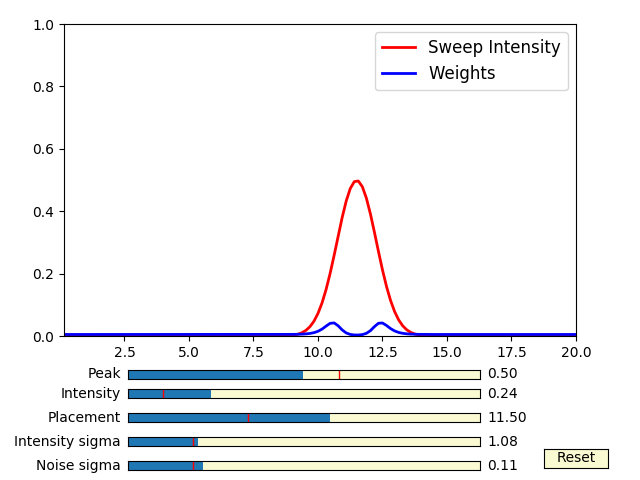

In [11]:
# Enable this if you want to visualize how the distrubition changes as we sweep a curtain across an object
sweep_mode = False
object_distance = 7

fig, ax = plt.subplots()
plt.subplots_adjust(left=0.1, bottom=0.3, top=0.95)

init_placement = 6.8
init_intensity = 0.1
init_inten_sigma = 1.0
init_noise_sigma = 0.1
init_peak = 0.6
if sweep_mode: plt.axvline(x=object_distance)

weights, mean_intensities = normalized_likelihoods(init_placement, init_intensity, init_inten_sigma, init_noise_sigma, init_peak)
l_mi, = plt.plot(D, mean_intensities, lw=2, c='red', label="Sweep Intensity")
l_weights, = plt.plot(D, weights, lw=2, c="blue", label="Weights")
plt.ylim([0.0, 1.0])
plt.legend(fontsize='large')
ax.margins(x=0)

axcolor = 'lightgoldenrodyellow'
ax_peak = plt.axes([0.2, 0.21, 0.55, 0.02], facecolor=axcolor)
ax_placement = plt.axes([0.2, 0.12, 0.55, 0.02], facecolor=axcolor)
if not sweep_mode: ax_intensity = plt.axes([0.2, 0.17, 0.55, 0.02], facecolor=axcolor)
ax_inten_sigma = plt.axes([0.2, 0.07, 0.55, 0.02], facecolor=axcolor)
ax_noise_sigma = plt.axes([0.2, 0.02, 0.55, 0.02], facecolor=axcolor)

s_peak = Slider(ax_peak, 'Peak', 0.0, 1.0, valinit=init_peak, valstep=0.0005)
s_placement = Slider(ax_placement, 'Placement', 0.0, 20.0, valinit=init_placement, valstep=0.0005)
if not sweep_mode: s_intensity = Slider(ax_intensity, 'Intensity', 0.0, 1.0, valinit=init_intensity, valstep=0.001)
s_inten_sigma = Slider(ax_inten_sigma, 'Intensity sigma', 0.1, 5.0, valinit=init_inten_sigma, valstep=0.001)
s_noise_sigma = Slider(ax_noise_sigma, 'Noise sigma', 0.01, 0.5, valinit=init_noise_sigma, valstep=0.001)

done = False
def update(val):
    placement = s_placement.val
    if not sweep_mode: intensity = s_intensity.val
    noise_sigma = s_noise_sigma.val
    inten_sigma = s_inten_sigma.val
    peak = s_peak.val
    print(peak)

    if sweep_mode:
        intensity = np.exp(- ((abs(placement-object_distance)) / inten_sigma) ** 2)

    weights, mean_intensities = normalized_likelihoods(placement, intensity, inten_sigma, noise_sigma, peak, sweep_mode)

    l_weights.set_ydata(weights)
    l_mi.set_ydata(mean_intensities)
    fig.canvas.draw_idle()

s_placement.on_changed(update)
if not sweep_mode: s_intensity.on_changed(update)
s_inten_sigma.on_changed(update)
s_noise_sigma.on_changed(update)
s_peak.on_changed(update)

resetax = plt.axes([0.85, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')

def reset(event):
    s_placement.reset()
    if not sweep_mode: s_intensity.reset()
    s_inten_sigma.reset()
    s_noise_sigma.reset()
button.on_clicked(reset)

plt.show()